In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from xgboost import XGBClassifier


def evaluate_all(y_true, proba, threshold=0.5):
    y_pred = (proba >= threshold).astype(int)
    return {
        "ROC-AUC": roc_auc_score(y_true, proba),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
    }

In [2]:
TRAIN_PATH = "DATA/preprocessed_train.csv"
VALID_PATH = "DATA/preprocessed_valid.csv"
TEST_PATH  = "DATA/preprocessed_test.csv"

In [3]:
df_tr = pd.read_csv(TRAIN_PATH)
df_va = pd.read_csv(VALID_PATH)
df_te = pd.read_csv(TEST_PATH)

In [4]:
df_tr.head()

,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,ID
0,37200,3,4.0,6,1,9000,0,0.24,1,6,23482
1,83000,3,0.0,2,4,14000,1,0.17,2,4,14094
2,50000,3,1.0,5,1,4000,0,0.08,1,2,3966
3,43200,2,4.0,1,1,6350,0,0.15,1,4,5052
4,70000,3,6.0,3,4,12000,0,0.17,2,5,25312


In [5]:
df_tr.shape


(20745, 11)

In [6]:
TARGET = "loan_status"
ID_COL = "ID"

X_tr = df_tr.drop(columns=[TARGET, ID_COL])
y_tr = df_tr[TARGET]

X_va = df_va.drop(columns=[TARGET, ID_COL])
y_va = df_va[TARGET]  

X_te = df_te.drop(columns=[TARGET, ID_COL])
y_te = df_te[TARGET]


pos = (y_tr == 1).sum()
neg = (y_tr == 0).sum()
scale_pos_weight = neg / max(pos, 1)  

xgb_model = XGBClassifier(
    n_estimators=2000,        
    learning_rate=0.03,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric="auc",    
    scale_pos_weight=scale_pos_weight,
    early_stopping_rounds=100, 
)

In [7]:
import xgboost
print(xgboost.__version__)


3.0.4


In [8]:
xgb_model.fit(
    X_tr, y_tr,
    eval_set=[(X_va, y_va)],
    verbose=False,
)
proba_va = xgb_model.predict_proba(X_va)[:, 1]
y_pred  = (proba_va >= 0.5).astype(int)

metrics_va = {
    "ROC-AUC": roc_auc_score(y_va, proba_va),
    "Accuracy": accuracy_score(y_va, y_pred),
    "Precision": precision_score(y_va, y_pred, zero_division=0),
    "Recall": recall_score(y_va, y_pred, zero_division=0),
    "F1": f1_score(y_va, y_pred, zero_division=0),
}
print(metrics_va)

{'ROC-AUC': 0.9499373416936785, 'Accuracy': 0.9267399267399268, 'Precision': 0.845861084681256, 'Recall': 0.8030713640469738, 'F1': 0.8239110287303059}


In [9]:
proba_te = xgb_model.predict_proba(X_te)[:, 1]
y_pred  = (proba_te >= 0.47).astype(int)

metrics_te = {
    "ROC-AUC": roc_auc_score(y_te, proba_te),
    "Accuracy": accuracy_score(y_te, y_pred),
    "Precision": precision_score(y_te, y_pred, zero_division=0),
    "Recall": recall_score(y_te, y_pred, zero_division=0),
    "F1": f1_score(y_te, y_pred, zero_division=0),
}
print(metrics_te)

{'ROC-AUC': 0.9440230745921733, 'Accuracy': 0.9142504626773597, 'Precision': 0.8051391862955032, 'Recall': 0.7994330262225372, 'F1': 0.802275960170697}


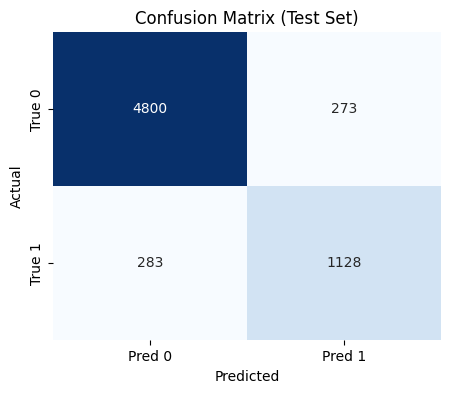

In [10]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_te, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=["Pred 0", "Pred 1"],
            yticklabels=["True 0", "True 1"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (Test Set)")
plt.show()

In [11]:
from sklearn.calibration import CalibratedClassifierCV, calibration_curve

proba_te_base = xgb_model.predict_proba(X_te)[:, 1]
m_base = evaluate_all(y_te, proba_te_base, threshold=0.47)

In [12]:
m_base

{'ROC-AUC': 0.9440230745921733,
 'Accuracy': 0.9142504626773597,
 'Precision': 0.8051391862955032,
 'Recall': 0.7994330262225372,
 'F1': 0.802275960170697}

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_calib, y_train, y_calib = train_test_split(
    X_tr, y_tr, test_size=0.2, random_state=42
)


platt = CalibratedClassifierCV(estimator=xgb_model, method="sigmoid", cv="prefit")
platt.fit(X_calib, y_calib)

proba_platt = platt.predict_proba(X_te)[:, 1]
print("PLATT ROC AUC:", roc_auc_score(y_te, proba_platt))


PLATT ROC AUC: 0.9440230745921733


/Users/sezermezgil/anaconda3/envs/tf_m1/lib/python3.10/site-packages/sklearn/calibration.py:330: FutureWarning: The `cv='prefit'` option is deprecated in 1.6 and will be removed in 1.8. You can use CalibratedClassifierCV(FrozenEstimator(estimator)) instead.
  warnings.warn(



=== RAW (uncalibrated) – TEST (thr=0.470) ===
 ROC-AUC: 0.9440
Accuracy: 0.9143
Precision: 0.8051
  Recall: 0.7994
      F1: 0.8023
   Brier: 0.0648
 LogLoss: 0.2238
     ECE: 0.0685

=== PLATT (calibrated) – TEST (thr=0.420) ===
 ROC-AUC: 0.9440
Accuracy: 0.9266
Precision: 0.8792
  Recall: 0.7682
      F1: 0.8200
   Brier: 0.0598
 LogLoss: 0.2463
     ECE: 0.0446


<Figure size 600x500 with 0 Axes>

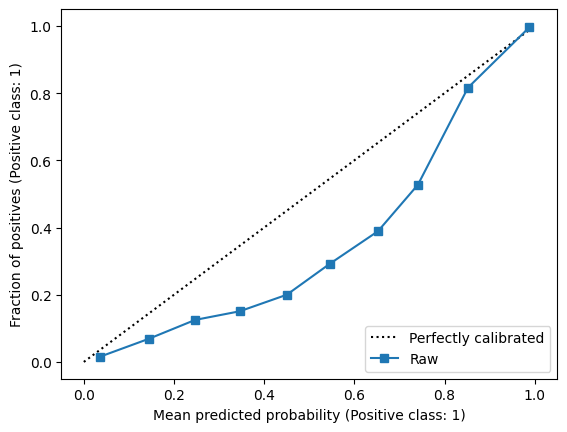

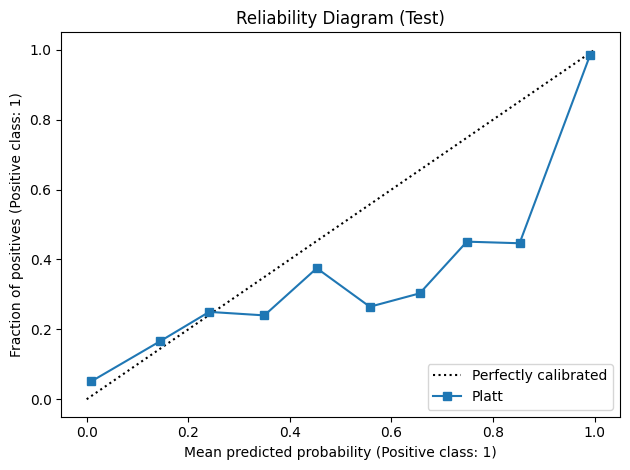

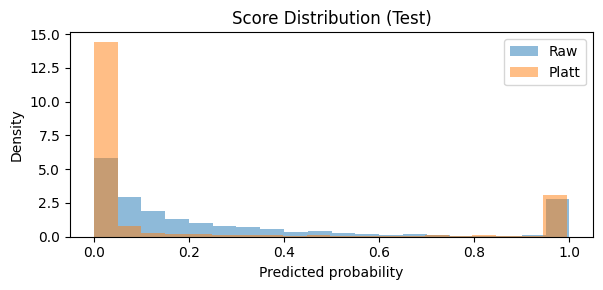

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score, f1_score,
    brier_score_loss, log_loss
)
from sklearn.calibration import CalibrationDisplay

def evaluate_all(y_true, proba, threshold=0.5):
    y_pred = (proba >= threshold).astype(int)
    return {
        "ROC-AUC": roc_auc_score(y_true, proba),
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "Brier": brier_score_loss(y_true, proba),
        "LogLoss": log_loss(y_true, proba),
    }

def expected_calibration_error(y_true, proba, n_bins=10):
    bins = np.linspace(0.0, 1.0, n_bins + 1)
    idx  = np.digitize(proba, bins) - 1
    ece  = 0.0
    for b in range(n_bins):
        mask = idx == b
        if mask.sum() == 0:
            continue
        conf = proba[mask].mean()
        acc  = y_true[mask].mean()
        w    = mask.mean()
        ece += w * abs(acc - conf)
    return ece

def print_block(title, y_true, proba, threshold):
    m = evaluate_all(y_true, proba, threshold=threshold)
    ece = expected_calibration_error(y_true, proba)
    print(f"\n=== {title} (thr={threshold:.3f}) ===")
    for k, v in m.items():
        print(f"{k:>8}: {v:.4f}")
    print(f"{'ECE':>8}: {ece:.4f}")

THR = 0.47  

proba_raw_te   = xgb_model.predict_proba(X_te)[:, 1]
proba_platt_te = platt.predict_proba(X_te)[:, 1]

print_block("RAW (uncalibrated) – TEST",  y_te, proba_raw_te,   THR)
print_block("PLATT (calibrated) – TEST", y_te, proba_platt_te, THR)

plt.figure(figsize=(6,5))
CalibrationDisplay.from_predictions(y_true=y_te, y_prob=proba_raw_te,   n_bins=10, name="Raw")
CalibrationDisplay.from_predictions(y_true=y_te, y_prob=proba_platt_te, n_bins=10, name="Platt")
plt.title("Reliability Diagram (Test)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3))
plt.hist(proba_raw_te,   bins=20, alpha=0.5, label="Raw", density=True)
plt.hist(proba_platt_te, bins=20, alpha=0.5, label="Platt", density=True)
plt.xlabel("Predicted probability")
plt.ylabel("Density")
plt.title("Score Distribution (Test)")
plt.legend()
plt.tight_layout()
plt.show()
